In [1]:
import os
from pycocotools.coco import COCO
from PIL import Image
import torch
from torchvision.transforms import ToTensor
from models.model import MyModel

/opt/conda/envs/mmm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [109]:
import argparse
parser = argparse.ArgumentParser(description='プログラムの説明')
 # Model setting
parser.add_argument('--image_model_name', type=str, default="microsoft/swinv2-base-patch4-window8-256", 
                    choices=[
                        "microsoft/resnet-50",
                        "microsoft/resnet-101",
                        "microsoft/resnet-152",
                        "microsoft/swinv2-base-patch4-window8-256",
                        "microsoft/swinv2-base-patch4-window16-256",
                        "microsoft/swinv2-base-patch4-window12-192-22k",
                        "microsoft/swinv2-large-patch4-window12-192-22k",
                    ], help='画像の特徴抽出モデル')
parser.add_argument('--image_model_train', action='store_true', help='画像の特徴抽出モデルを学習するかどうか')
parser.add_argument('--language_model_name', type=str, default='t5-large', 
                    choices=[
                        't5-small', 't5-base', 't5-large', 't5-3b', 't5-11b',
                        'google/flan-t5-small', 'google/flan-t5-base', 'google/flan-t5-large', 'google/flan-t5-xl', 'google/flan-t5-xxl',
                    ], help='言語の特徴抽出モデル')
parser.add_argument('--ffn', action='store_true', help='特徴抽出モデルの出力をFFNで変換するかどうか')
parser.add_argument('--transformer_model_name', type=str, default='t5-large', 
                    choices=[
                        't5-small', 't5-base', 't5-large', 't5-3b', 't5-11b',
                        'google/flan-t5-small', 'google/flan-t5-base', 'google/flan-t5-large', 'google/flan-t5-xl', 'google/flan-t5-xxl',
                    ], help='メインTransformerのモデル')
parser.add_argument('--max_source_length', type=int, default=256, help='入力文の最大長')
parser.add_argument('--max_target_length', type=int, default=128, help='出力文の最大長')
# Training setting
parser.add_argument('--batch_size', type=int, default=64, help='1GPUあたりのバッチサイズ')
# Dir setting
parser.add_argument('--data_dir', type=str, default='/data/dataset/mscoco2017/', help='データのディレクトリ')
parser.add_argument('--result_dir', type=str, default='results/', help='結果を保存するディレクトリ')

args = parser.parse_args([
    "--ffn",
    "--transformer_model_name", "t5-large",
    "--result_dir", "results/caption/only_transformer/t5-large/ffn_no_scheduler"
])

In [110]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [111]:
model = MyModel(args).to(device)
model.load(result_name='epoch_50.pth')

In [112]:
from transformers import AutoImageProcessor, AutoTokenizer
image_processor = AutoImageProcessor.from_pretrained(args.image_model_name)
tokenizer = AutoTokenizer.from_pretrained(args.language_model_name, model_max_length=512)

In [113]:
# Load COCO
phase = 'train'
anno_path = os.path.join(args.data_dir, 'annotations', f'captions_{phase}2017.json')
coco = COCO(anno_path)
img_dir = os.path.join(args.data_dir, f'{phase}2017')

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


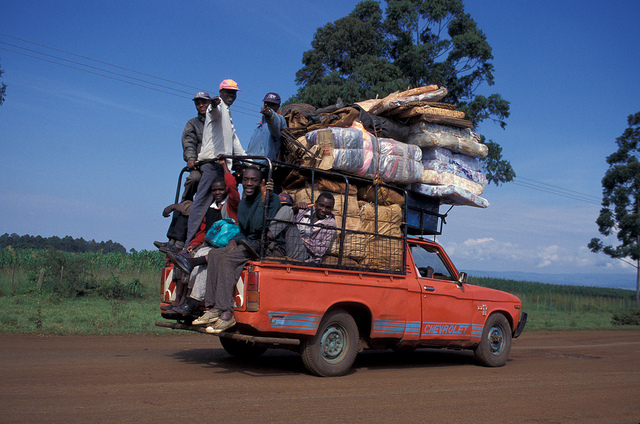

GT: A group of people riding on the back of a loaded red pickup truck.
Pred: A group of people riding on the back of a loaded red pickup truck.


In [114]:
for i, image_id in enumerate(coco.getImgIds()):
    if i != 20:
        continue
    image_info = coco.loadImgs(image_id)[0]
    img_name = image_info['file_name']
    img_path = os.path.join(img_dir, img_name)

    caption = coco.loadAnns(coco.getAnnIds(image_id))[0]['caption']
    break

image = Image.open(img_path).convert('RGB')
display(image)
transform = ToTensor()
image = transform(image.resize((256,256)))
src_text = 'What does the image describe ?'
with torch.no_grad():
    processed_image = image_processor(image, return_tensors="pt").to(device)
    source_encoding = tokenizer(src_text, padding="longest", max_length=args.max_source_length, return_tensors='pt').to(device)
    output = model(processed_image, source_encoding, return_loss=False)
print(f'GT: {caption}')
print(f'Pred: {tokenizer.decode(output[0], skip_special_tokens=True)}')